In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

2023-05-21 08:00:39.715429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

# Load the dataset
df = pd.read_csv("/Users/user/Documents/datasets/paysim.csv")


In [3]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
# Drop irrelevant columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Encode categorical features
df['type'] = df['type'].replace({'CASH_OUT': 0, 'TRANSFER': 1, 'PAYMENT': 2, 'DEBIT': 3, 'CASH_IN': 4})

# Standardize the features
scaler = StandardScaler()
df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

# Split the dataset into features and target
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Create a Variational Autoencoder to generate synthetic fraud data
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)

z_mean = Dense(encoding_dim, name='z_mean')(encoder)
z_log_var = Dense(encoding_dim, name='z_log_var')(encoder)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])

decoder = Dense(int(encoding_dim / 2), activation='tanh')(z)
decoder = Dense(input_dim, activation='relu')(decoder)

vae = Model(inputs=input_layer, outputs=decoder)

# Compute the VAE loss
reconstruction_loss = tf.keras.losses.mean_squared_error(input_layer, decoder)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * tf.keras.backend.sum(kl_loss, axis=-1)
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

# Train the VAE on normal transactions
X_normal = X_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)
vae.compile(optimizer='adam')
history = vae.fit(X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, None)) # epoch = 100

# Generate synthetic fraud transactions using the trained VAE
X_fraud = X_train[y_train == 1]
synthetic_fraud = vae.predict(X_fraud)

# Add noise to the synthetic fraud transactions
noise_factor = 0.2
synthetic_fraud_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_noisy))

# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

2023-05-21 08:19:06.640058: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_2/bias/Assign' id:137 op device:{requested: '', assigned: ''} def:{{{node dense_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/bias, dense_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-21 08:19:06.655005: W tensorflow/c/c_api.cc:300] Operation '{name:'Mean/reduction_indices' id:169 op device:{requested: '', assigned: ''} def:{{{node Mean/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes aft

Train on 4066802 samples, validate on 1016701 samples
Epoch 1/100
   6176/4066802 [..............................] - ETA: 3:47 - loss: 1.5064  

2023-05-21 08:19:08.435142: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_2/kernel/v/Assign' id:516 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/kernel/v, training/Adam/dense_2/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4063968/4066802 [============================>.] - ETA: 0s - loss: 1.0338

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-21 08:20:12.273382: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/AddN' id:203 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](dense/ActivityRegularizer/truediv, Mean_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4066802/4066802 [==============================] - 73s 18us/sample - loss: 1.0336 - val_loss: 1.0054
Epoch 2/100
4066802/4066802 [==============================] - 79s 19us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 3/100
4066802/4066802 [==============================] - 93s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 4/100
4066802/4066802 [==============================] - 95s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 5/100
4066802/4066802 [==============================] - 97s 24us/sample - loss: 1.0322 - val_loss: 1.0056
Epoch 6/100
4066802/4066802 [==============================] - 97s 24us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 7/100
4066802/4066802 [==============================] - 96s 24us/sample - loss: 1.0322 - val_loss: 1.0055
Epoch 8/100
4066802/4066802 [==============================] - 97s 24us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 9/100
4066802/4066802 [==============================] - 97s 24us/sample - loss: 1.0322 - val_loss: 1.

4066802/4066802 [==============================] - 92s 23us/sample - loss: 1.0322 - val_loss: 1.0055
Epoch 74/100
4066802/4066802 [==============================] - 92s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 75/100
4066802/4066802 [==============================] - 93s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 76/100
4066802/4066802 [==============================] - 93s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 77/100
4066802/4066802 [==============================] - 92s 23us/sample - loss: 1.0322 - val_loss: 1.0055
Epoch 78/100
4066802/4066802 [==============================] - 92s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 79/100
4066802/4066802 [==============================] - 93s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 80/100
4066802/4066802 [==============================] - 93s 23us/sample - loss: 1.0322 - val_loss: 1.0054
Epoch 81/100
4066802/4066802 [==============================] - 93s 23us/sample - loss: 1.0322 - val_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-21 10:50:59.684072: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/Relu' id:167 op device:{requested: '', assigned: ''} def:{{{node dense_3/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [6]:
# Apply SMOTE Oversampling to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_balanced, y_balanced)

In [7]:
# Fit the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.999233806199333
Confusion matrix:
 [[1269986     918]
 [     57    1563]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.63      0.96      0.76      1620

    accuracy                           1.00   1272524
   macro avg       0.81      0.98      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


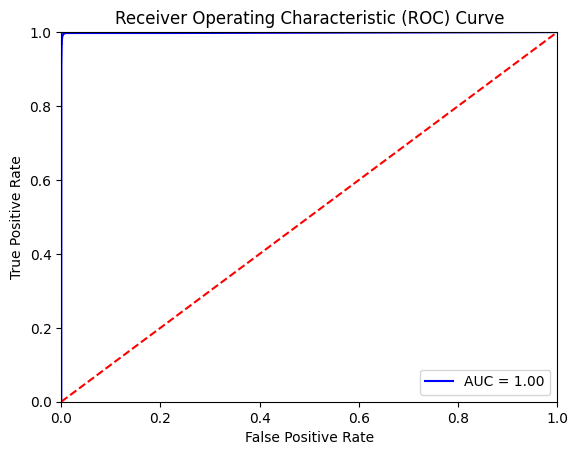

In [8]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion matrix:\n', cm)

from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, auc, matthews_corrcoef, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))

y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 0.999234
F1-score:  0.7622531089978054
Precision:  0.6299879081015719
Recall:  0.9648148148148148
Specificity:  0.9992776795100181
Sensitivity:  0.9648148148148148
AUC:  0.9984021087682274
Matthews correlation coefficient: 0.7793095308592622


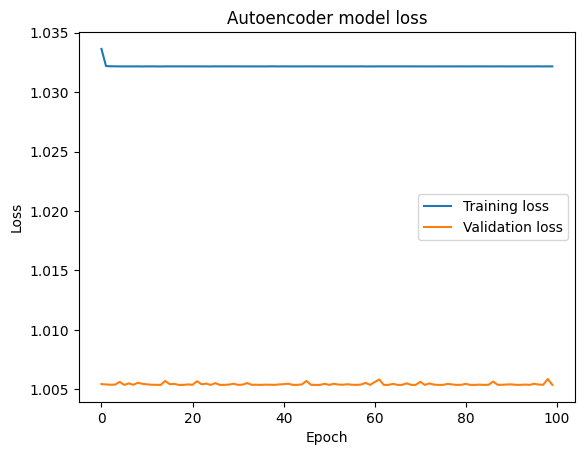

In [9]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy: %f" % accuracy)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

# plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
##

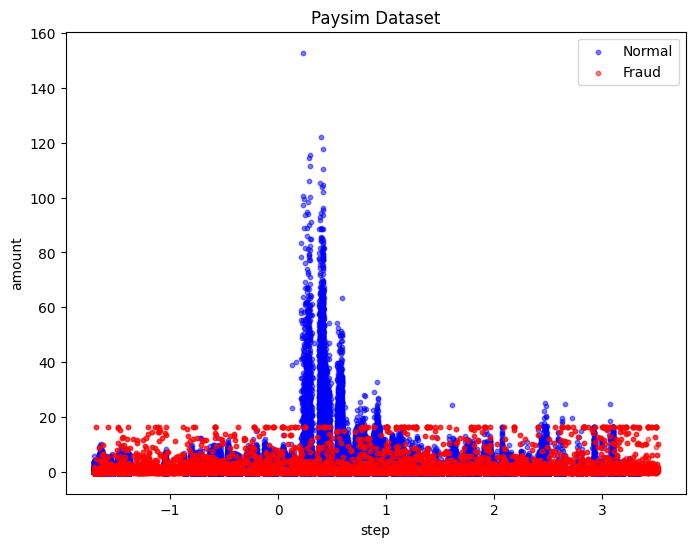

In [21]:
# Separate the normal and fraud data
normal_data = df[df['isFraud'] == 0]
fraud_data = df[df['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("Paysim Dataset")
plt.scatter(normal_data['step'], normal_data['amount'], c="blue", label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['step'], fraud_data['amount'], c="red", label='Fraud', s=10, alpha=0.5)
plt.xlabel("step")
plt.ylabel("amount")
plt.legend()
plt.show()

In [16]:
df1 = np.column_stack([X_train_balanced, y_train_balanced])
df2 = np.column_stack([X_test, y_test])

In [17]:
df3 = np.vstack([df1, df2])

In [18]:
df4 = pd.DataFrame(df3, columns = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                                   'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'isFraud'])

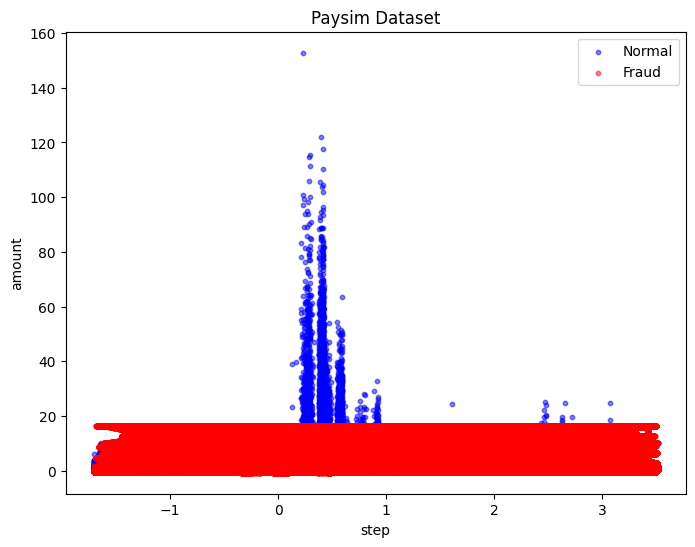

In [22]:
# Separate the normal and fraud data
normal_data = df4[df4['isFraud'] == 0]
fraud_data = df4[df4['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("Paysim Dataset")
plt.scatter(normal_data['step'], normal_data['amount'], c="blue", label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['step'], fraud_data['amount'], c="red" , label='Fraud', s=10, alpha=0.5)
plt.xlabel("step")
plt.ylabel("amount")
plt.legend()
plt.show()